In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist

In [3]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## Helper Classes

In [4]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass')

## Trained Classification Models

In [5]:
MODEL_DETAILS_DICT = {
    # BNN
    "bnn_1200": ModelDetails("../saved_models/BBB_classification/2022-03-15-09.18.07", ClassificationBNN),
    "bnn_800": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.25.46", ClassificationBNN),
    "bnn_400": ModelDetails("../saved_models/BBB_classification/2022-03-15-14.26.34", ClassificationBNN),
    # DNN - no dropout
    "dnn_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-14.28.25", ClassificationDNN),
    "dnn_800": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.06.09", ClassificationDNN),
    "dnn_400": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.10.34", ClassificationDNN),
    # DNN - dropout
    "dnn_do_400": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.21.46", ClassificationDNN),
    "dnn_do_800": ModelDetails("../saved_models/DNN_classification/2022-03-15-15.58.04", ClassificationDNN),
    "dnn_do_1200": ModelDetails("../saved_models/DNN_classification/2022-03-15-16.26.18", ClassificationDNN),
}

bnn_1200_10_epoch = ModelDetails("../saved_models/BBB_classification/2022-03-16-16.59.02", ClassificationBNN)

## Set Model

In [6]:
MODEL = "bnn_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
MODEL_DETAILS

ModelDetails(dir='../saved_models/BBB_classification/2022-03-15-09.18.07', mclass=<class 'bbb.models.bnn.ClassificationBNN'>)

## Load Parameters

In [7]:
with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
    params_dict = json.load(f)

# Need to deserialise the prior_params into a PriorParameters object
if params_dict['prior_params']:
    params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

params = Parameters(**params_dict)
params

Parameters(name='BBB_classification', input_dim=784, output_dim=10, batch_size=128, epochs=300, hidden_units=1200, hidden_layers=3, lr=0.0001, step_size=75, opt_choice='Adam', gamma=0.1, weight_mu_range=[-0.2, 0.2], weight_rho_range=[-5, -4], prior_params=PriorParameters(w_sigma=1.0, b_sigma=1.0, w_sigma_2=0.2, b_sigma_2=0.2, w_mixture_weight=0.5, b_mixture_weight=0.5), elbo_samples=2, inference_samples=10, regression_likelihood_noise=None, kl_reweighting_type=1, vp_variance_type=1, prior_type=0, local_reparam_trick=False, dropout=False, dropout_p=None, early_stopping=False, early_stopping_thresh=0, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

## Load Data

In [8]:
X_val = load_mnist(train=False, batch_size=params.batch_size, shuffle=True)

/homes/ajc348/BBB/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Load Model

In [9]:
# net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

2022-03-25 19:18:08,828 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:18:08,828 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:18:08,855 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:18:08,856 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:18:08,858 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:18:08,858 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

## Evaluate

In [10]:
def evaluate_classifier(net, X_val):
    correct = 0
    total = 0

    # Logging
    dict = {}
    dict['labels'] = []
    dict['probs'] = {}
    dict['preds'] = {}
    dict['preds']['incorrect'] = []
    dict['preds']['correct'] = []
    dict['preds']['all'] = []

    dict['probs']['all'] = []
    dict['probs']['max'] = []

    dict['probs']['incorrect'] = {}
    dict['probs']['correct'] = {}
    dict['probs']['incorrect']['all'] = []
    dict['probs']['correct']['all'] = []
    dict['probs']['incorrect']['max'] = []
    dict['probs']['correct']['max'] = []

    # Eval & save results appropriately
    with torch.no_grad():
        for inputs, labels in X_val:
            # inputs = inputs.to(DEVICE)
            # labels = labels.to(DEVICE)
            
            preds, probs = net.predict(inputs)

            total += net.batch_size
            correct += (labels == preds).sum()

            # create two arrays;
            preds = preds.cpu().detach().numpy()
            probs = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            correct_filter = np.where(labels == preds)
            incorrect_filter = np.where(labels != preds)

            correct_preds = preds[correct_filter]
            correct_probs = probs[correct_filter]
            
            incorrect_preds = preds[incorrect_filter]
            incorrect_probs = probs[incorrect_filter]


            dict['labels'].extend(labels)
            dict['probs']['all'].extend(probs) 
            dict['preds']['all'].extend(preds)
            
            dict['probs']['max'].append(np.max(probs, axis=1))
            
            dict['preds']['incorrect'].extend(incorrect_preds)
            dict['preds']['correct'].extend(correct_preds)
            
            dict['probs']['incorrect']['all'].extend(incorrect_probs)
            dict['probs']['correct']['all'].extend(correct_probs)

    eval_score = correct / total

    dict['eval_score'] = eval_score
    return dict
    

In [11]:
eval_dict = evaluate_classifier(net, X_val)
eval_dict['eval_score']

tensor(0.9845)

## Plot Weights

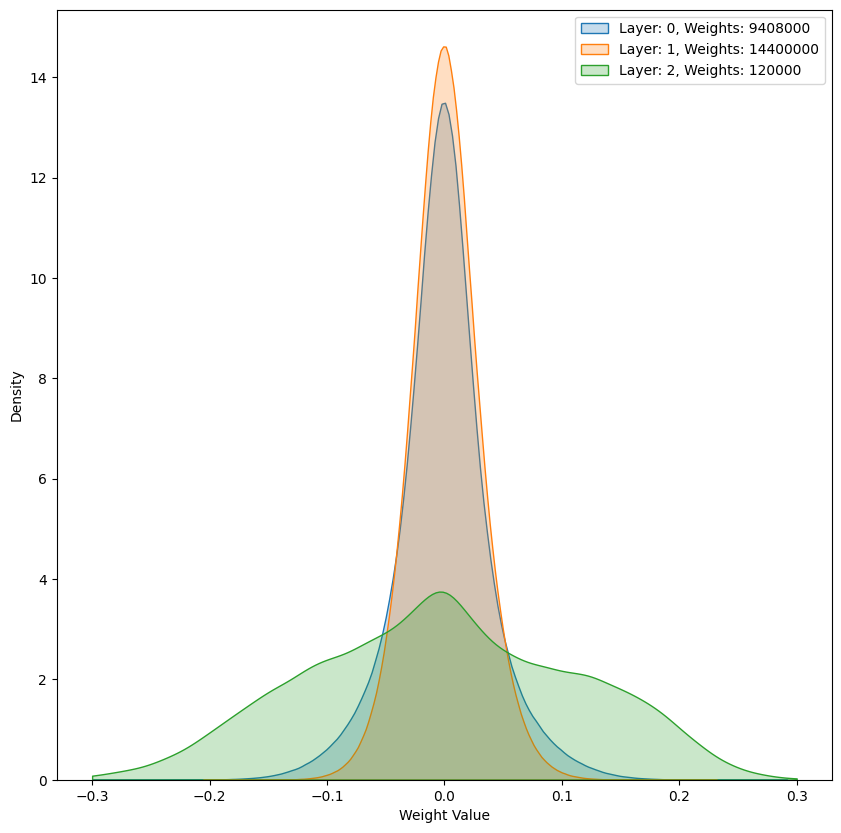

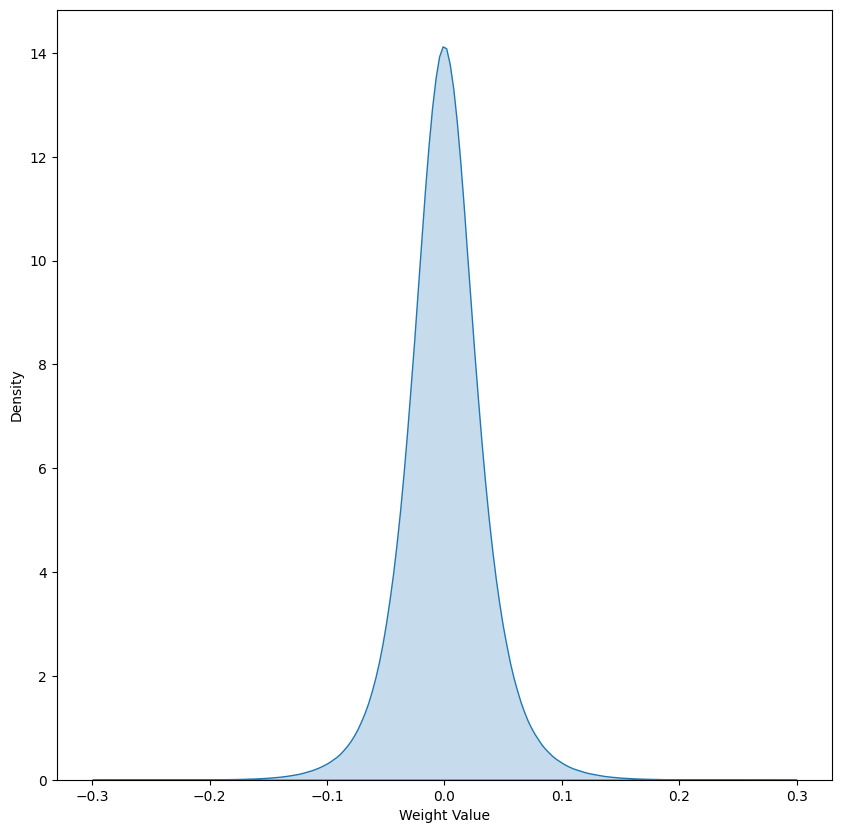

In [12]:
plot_weight_samples(net.weight_samples())

## Remove Weight with Low S/N Ratio

In [13]:
weight_mean_tensors, weight_std_tensors = net.get_weights()
weight_snr_tensors = [10*torch.log10(torch.abs(weight_mean_tensors[i])/weight_std_tensors[i]) for  i in range(len(weight_mean_tensors))]

In [14]:
weight_snrs = np.array([])
for i in weight_snr_tensors:
    weight_snrs = np.hstack((weight_snrs, i.flatten().detach().numpy()))

<AxesSubplot:ylabel='Density'>

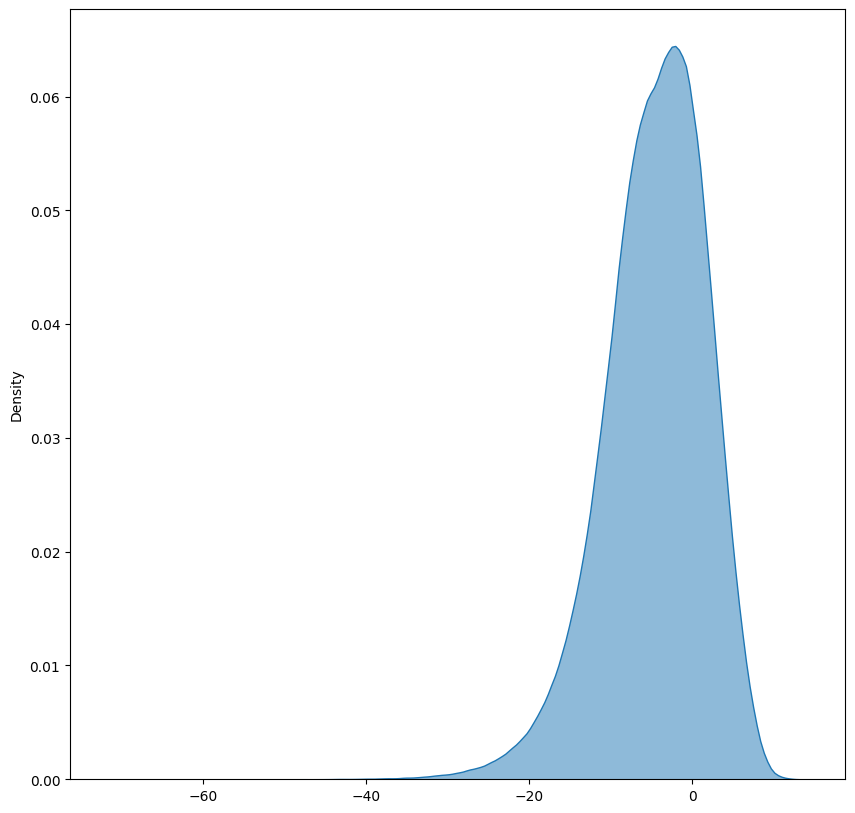

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# ax.hist(weight_snrs, density=True, bins=50)
sns.kdeplot(weight_snrs, fill=True, ax=ax, alpha=0.5)

<AxesSubplot:ylabel='Proportion'>

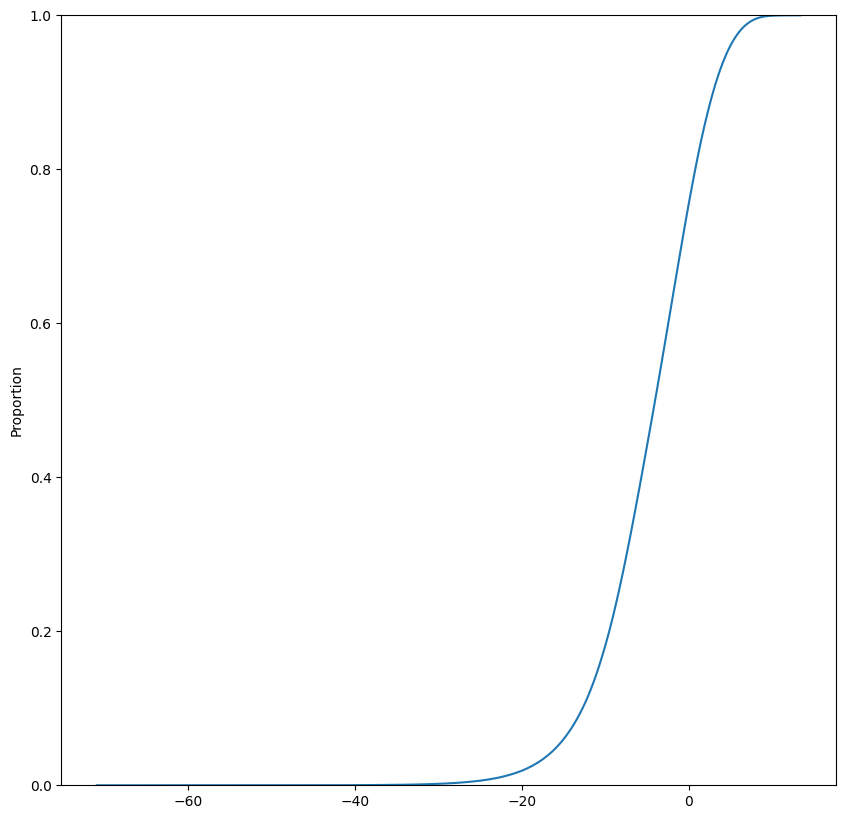

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# ax.hist(weight_snrs, density=True, bins=50)
sns.ecdfplot(weight_snrs, ax=ax)

In [17]:
snr_threshold_quantile = 0.75
snr_threshold = np.quantile(weight_snrs, snr_threshold_quantile)
snr_threshold

-0.10223251394927502

In [18]:
weight_fill_masks = [
    weight_snr_tensors[i] < snr_threshold for i in range(len(weight_snr_tensors))
]

In [19]:
net.prune_weights(weight_fill_masks)

In [20]:
eval_dict = evaluate_classifier(net, X_val)
eval_dict['eval_score']

tensor(0.9845)

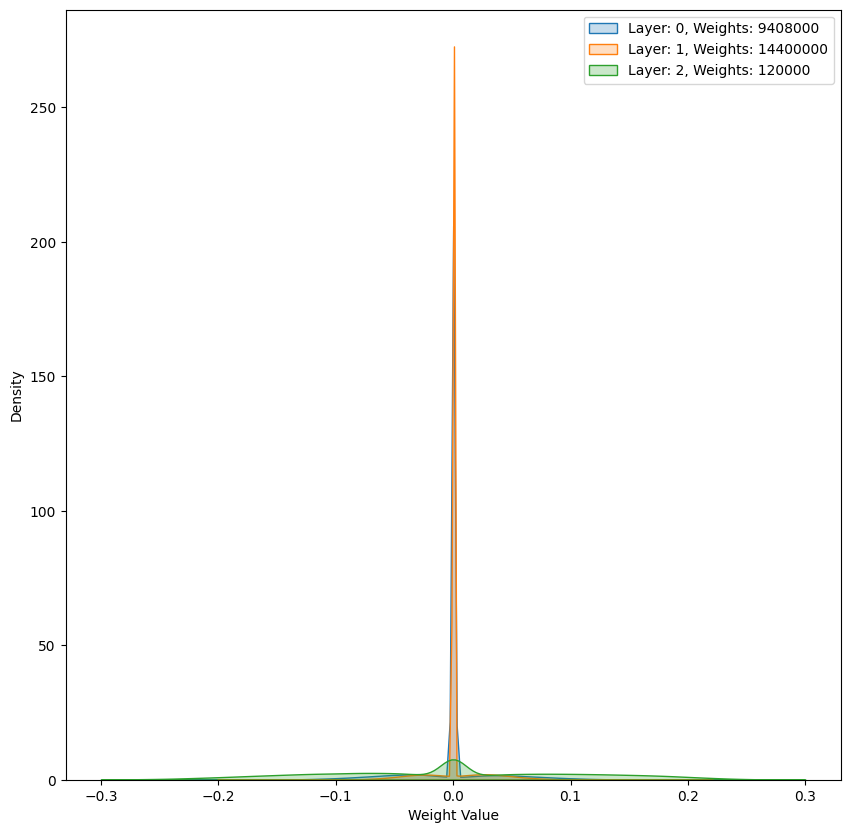

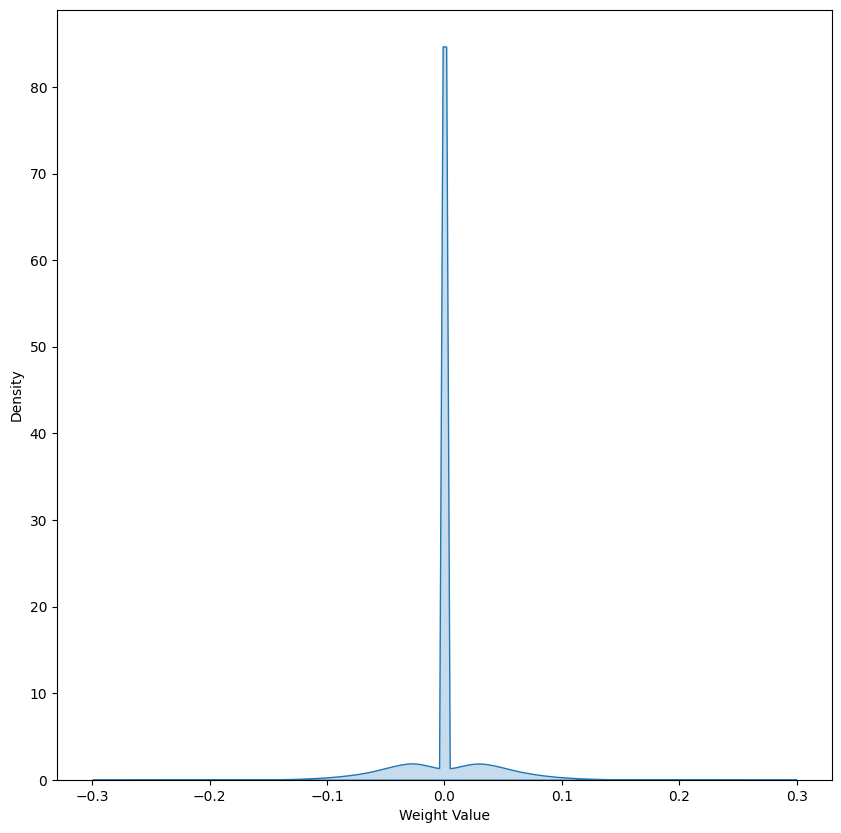

In [21]:
plot_weight_samples(net.weight_samples())

## Analyse Multiple Models

### Evaluation

In [23]:
models = ['bnn_1200', 'dnn_do_1200', 'dnn_1200']
model_dict = {}

for model in models:
    
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

    model_dict[model] = evaluate_classifier(net, X_val)
    print('{}: {}'.format(model, model_dict[model]['eval_score']))

2022-03-25 19:06:19,136 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,137 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,153 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,153 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,155 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:06:19,155 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


bnn_1200: 0.9849759340286255
dnn_do_1200: 0.9846754670143127
dnn_1200: 0.9830729365348816


In [24]:
# Create list of maximum confidence score for each guess
for model in models:
    dict = model_dict[model]

    for i in dict['probs']['incorrect']['all']:
        dict['probs']['incorrect']['max'].append(np.max(i))

    for i in dict['probs']['correct']['all']:
        dict['probs']['correct']['max'].append(np.max(i))

    model_dict[model]['probs']['max'] = np.array(model_dict[model]['probs']['max']).flatten()

Plot weight distribution 


2022-03-25 19:08:35,517 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,518 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,538 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,539 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,541 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-25 19:08:35,541 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


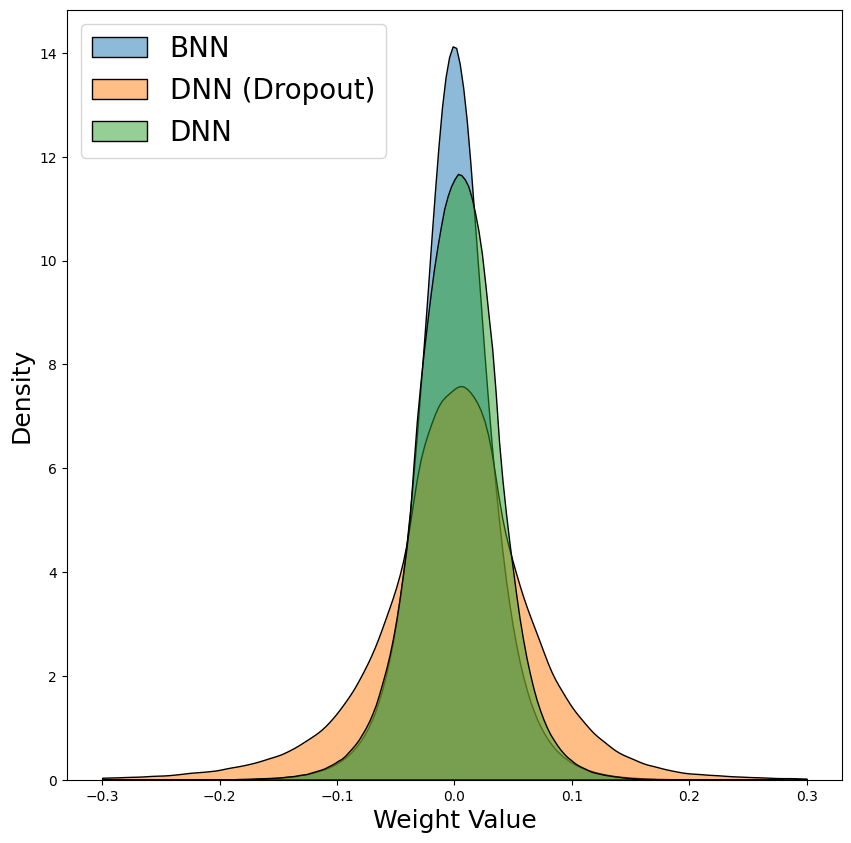

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
# Formatting of plot
ax.set_xlabel('Weight Value', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


for idx, model in enumerate(models):
    MODEL_DETAILS = MODEL_DETAILS_DICT[model]
    
    # Load params
    with open(os.path.join(MODEL_DETAILS.dir, 'params.txt'), 'r') as f:
        params_dict = json.load(f)

    # Need to deserialise the prior_params into a PriorParameters object
    if params_dict['prior_params']:
        params_dict['prior_params'] = PriorParameters(**params_dict['prior_params'])

    params = Parameters(**params_dict)

    # Load model
    net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
    net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

    weight_samples = net.weight_samples()

    comb_weight_samples = torch.hstack(weight_samples)
    sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, clip=[-0.3, 0.3], ax=ax, color=colors[idx], alpha=0.5, multiple="stack")
    # ax.hist(comb_weight_samples.flatten().detach().cpu().numpy(), **histogram_args)

    
# Display the plot
ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
plt.savefig(os.path.join("../plots/classification/comb_weights_plot_1200.png"), pad_inches=0.2, bbox_inches='tight')
plt.show()

Plot reliability diagram

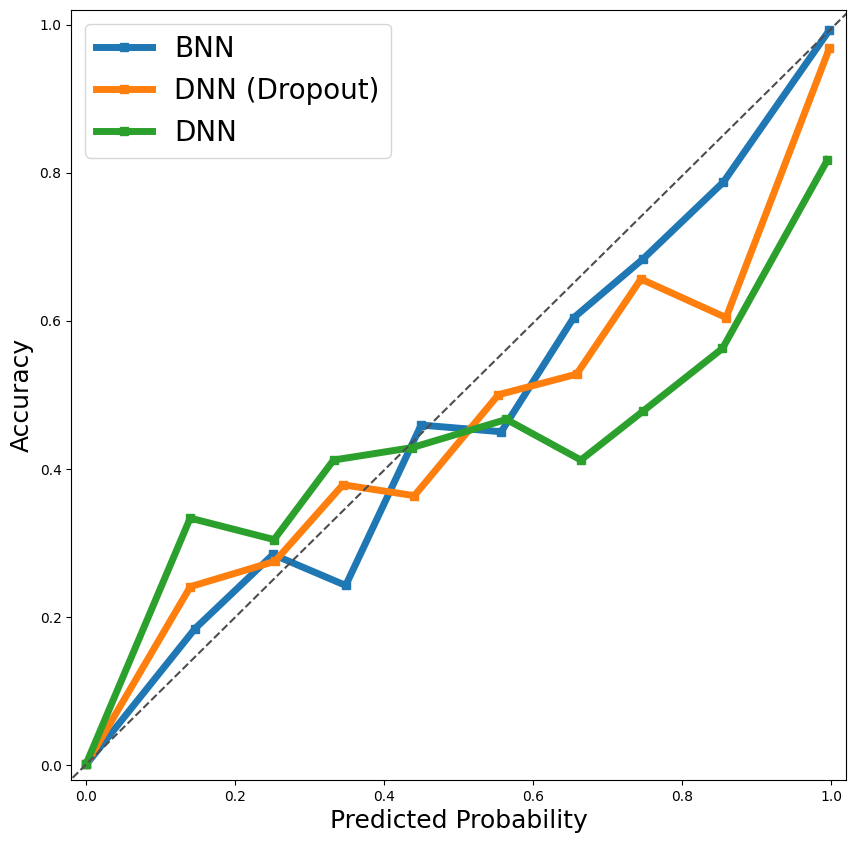

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for idx, model in enumerate(models):

    probs = model_dict[model]['probs']['all']
    conf = model_dict[model]['probs']['max']
    preds = model_dict[model]['preds']['all']
    labels = model_dict[model]['labels']
    
    bins = 10
    B = {}
    for i in range(bins+1):
        B[i] = [0,0,0]

    pred_prob = np.array(probs)
    for n in range(np.shape(preds)[0]):
        for d in range(np.max(labels)+1):
            whichBin = int(pred_prob[n][d]*bins)
            B[whichBin][0] += 1
            if d == labels[n]: B[whichBin][1] += 1
            B[whichBin][2] += pred_prob[n][d]

    correct = []
    predicted = []
    for i in range(bins):
        correct.append(B[i][1]/B[i][0])
        predicted.append(B[i][2]/B[i][0])


    ax.plot(predicted, correct, 's-', linewidth=5,
             label="{}".format(model), color=colors[idx])

ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
ax.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(-0.02,1.02)
ax.set_xlabel("Predicted Probability", fontsize=18)
ax.set_ylabel("Accuracy", fontsize=18)
# ax.set_title("Reliability Diagram")

plt.savefig('../plots/classification/reliability_1200.png', bbox_inches='tight')
plt.show()

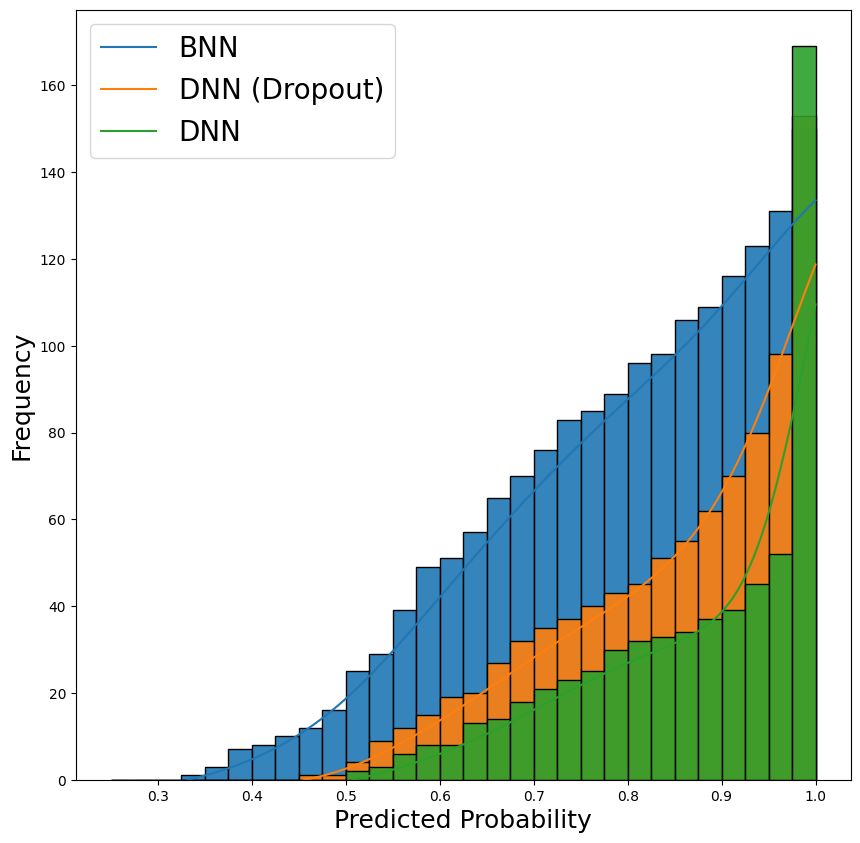

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['incorrect']['max'], bins=np.arange(0.25,1.025,0.025), label=model, alpha=0.9, kde=True, cumulative=True, color=sns.color_palette("tab10")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(['BNN', 'DNN (Dropout)', 'DNN'], loc='upper left', prop={'size':20})
# ax.set_title("Confidence scores of incorrect predictions")
ax.set_xlabel("Predicted Probability", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)

plt.savefig('../plots/classification/incorrect_1200.png', bbox_inches='tight')
plt.show()

## Plot weight distribution for model

In [ ]:
plot_weight_samples(net.weight_samples())

## Don't use the reliability diagram below

[0.         0.         0.         0.25       0.2777778  0.5
 0.49056605 0.6944444  0.7777778  0.9917292 ]
<class 'numpy.ndarray'>


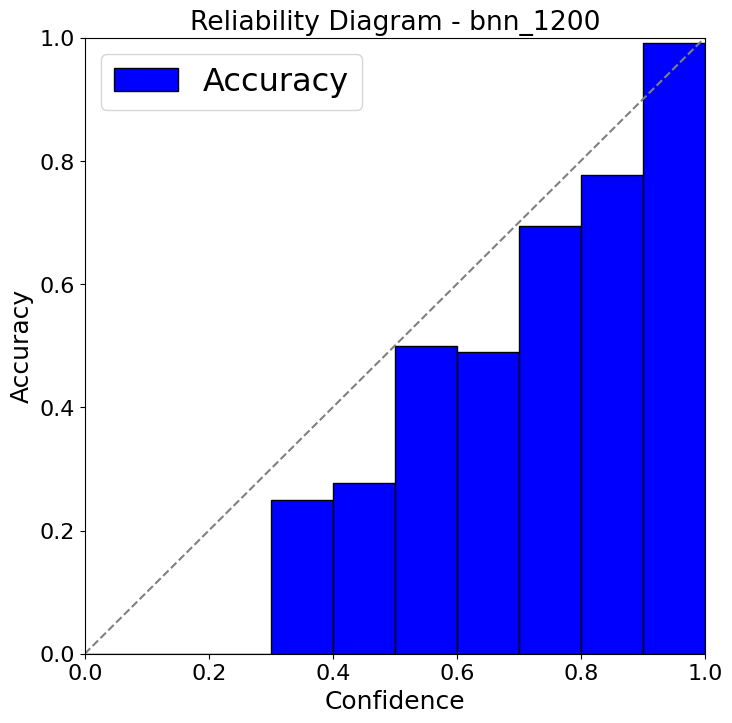

[0.         0.         0.         1.         0.         0.5
 0.5277778  0.65625    0.6041667  0.96813464]
<class 'numpy.ndarray'>


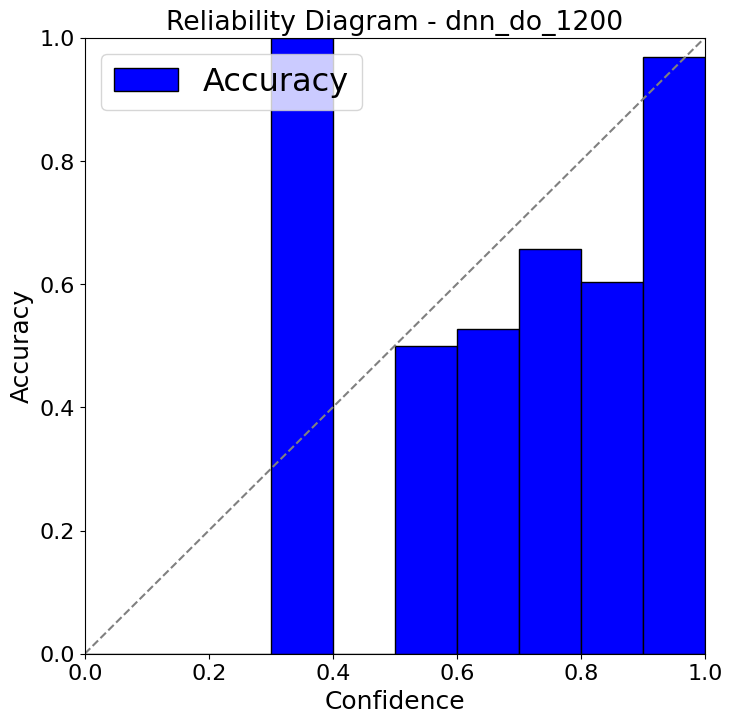

[0.         0.         0.         0.         0.         0.46666667
 0.4117647  0.47826087 0.5625     0.8171141 ]
<class 'numpy.ndarray'>


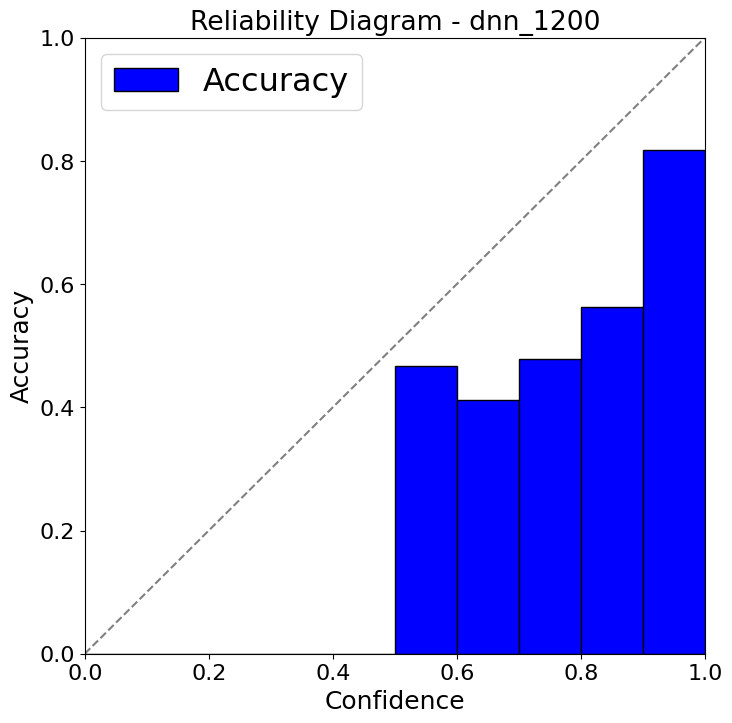

In [33]:
from ece_loss import make_model_diagrams

for model in models:

    probs = model_dict[model]['probs']['all']
    conf = model_dict[model]['probs']['max']
    preds = model_dict[model]['preds']['all']
    labels = model_dict[model]['labels']

    make_model_diagrams(probabilities=torch.from_numpy(np.array(probs)), predictions=torch.from_numpy(np.array(preds)), confidences=torch.from_numpy(np.array(conf)), labels=torch.from_numpy(np.array(labels)), model=model, n_bins=10)


# Histogram plots of incorrect/correct predictions

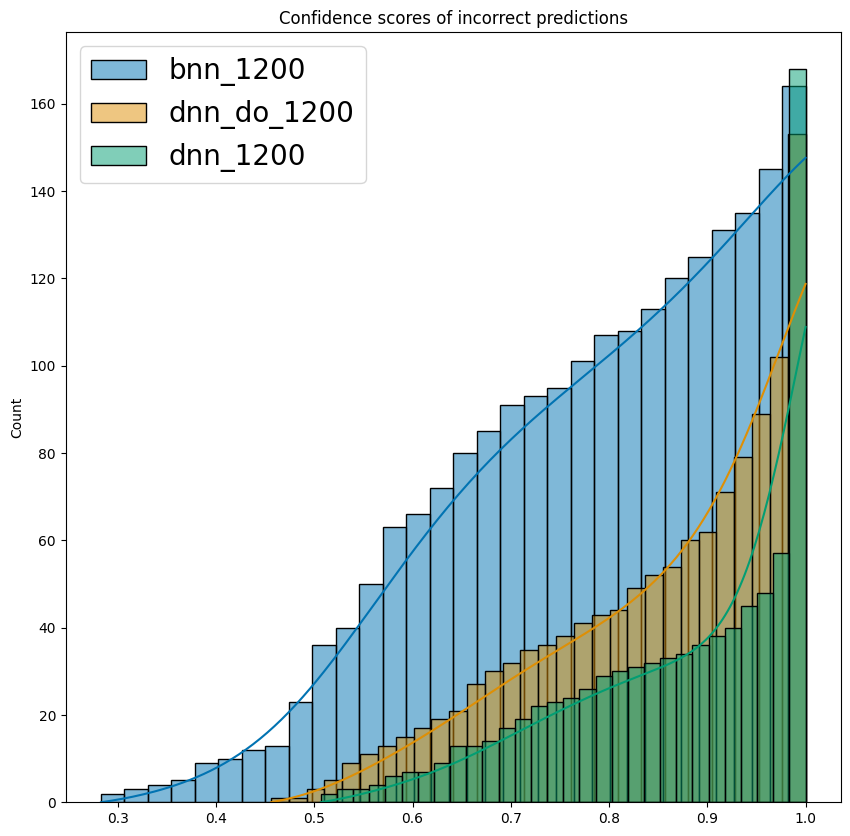

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5, kde=True, cumulative=True, color=sns.color_palette("colorblind")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(loc='upper left', prop={'size':20})
ax.set_title("Confidence scores of incorrect predictions")
plt.show()

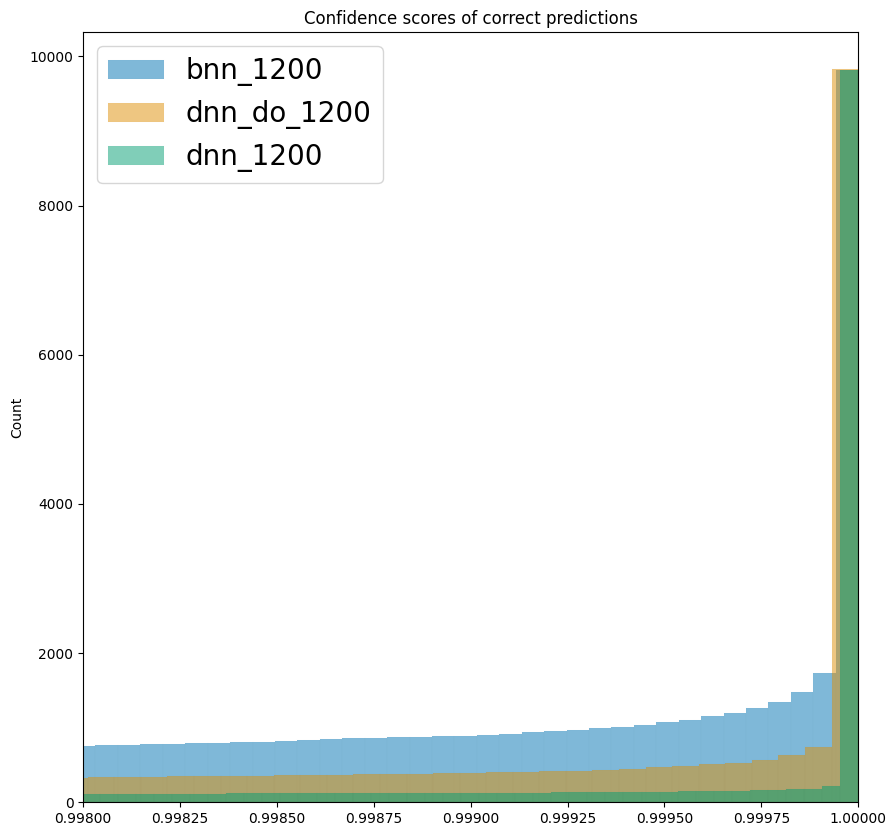

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i, model in enumerate(models):
    dict = model_dict[model]

    ax = sns.histplot(ax=ax, data=dict['probs']['correct']['max'], bins=10000, label=model, alpha=0.5, kde=False, cumulative=True, color=sns.color_palette("colorblind")[i])

    # ax.hist(dict['probs']['incorrect']['max'], bins=30, label=model, alpha=0.5)    
    # ax.hist(dict['probs']['correct']['max'], bins=10, label='Correct', alpha=0.5)

ax.legend(loc='upper left', prop={'size':20})
ax.set_xlim([0.998, 1.0])
ax.set_title("Confidence scores of correct predictions")
plt.show()

## Recorded Metrics

In [ ]:
from IPython.display import Image
comb_weights_plot_path = os.path.join(MODEL_DETAILS.dir, 'comb_weights_plot.png')
Image(filename=comb_weights_plot_path) 

In [19]:
eval_metric = np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))

In [21]:
eval_metric[-1]

0.9863781929016113

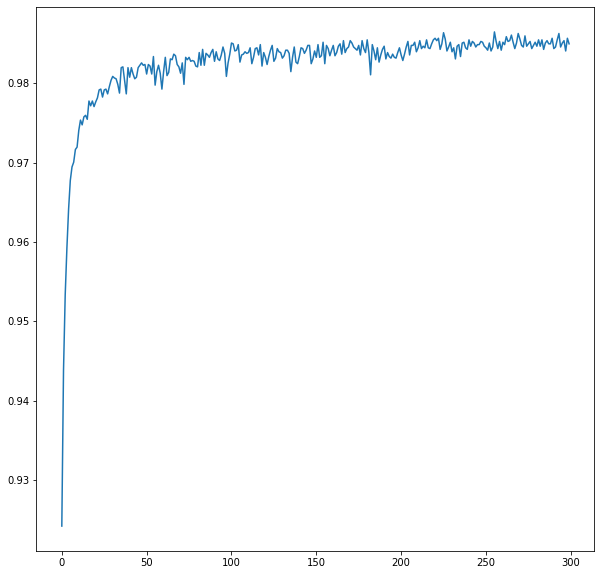

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(eval_metric)

In [ ]:
loss = np.load(os.path.join(MODEL_DETAILS.dir, 'loss.npy'))

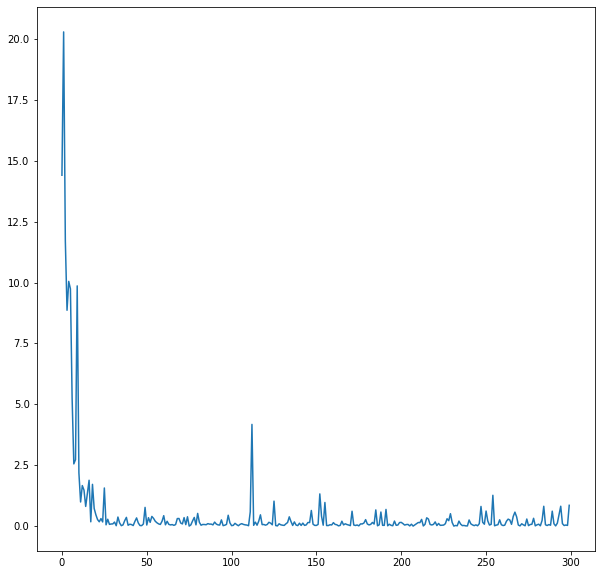

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(loss)